## Making predictions on the validation set

This notebook uses a previously stored model to make predictions on the data from the **validation** set. It outputs a submission file (csv) as well as storing the annotations made to file as PNG image - the same as the masks! 

### Importing the important stuff

In [1]:
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import logging
from os.path import join, basename, dirname, exists  
import os  
%matplotlib notebook

# Keras
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Input, Model
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Flatten, Dropout, UpSampling2D, core
from keras.callbacks import ModelCheckpoint

# Other
import seaborn as sns
import skimage
import pandas as pd
import sklearn
from scipy.ndimage import imread 
from skimage.measure import label, regionprops
from sklearn import feature_extraction
from IPython.display import clear_output
from sklearn.metrics import precision_recall_curve
from PIL import Image
Image.MAX_IMAGE_PIXELS = 2201136600 #because Pillow will whine to no end if you feed it big images. You're welcome.

Using TensorFlow backend.


### Some Configuration

In [2]:
# define a sample image for showing how the image transformatins
IMAGE_PATH = "data/validation_images/27_CD3_ROI_2.png"
IMAGE_DIR = "/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/validation_images"
PATCH_WIDTH = 512
PATCH_HEIGHT = 512
BORDER_TYPE="CONSTANT"
result_dir = 'Validation_Results'

### Patch-creating functions
In order to make predictions we actually need to cope with the different image sizes as they have a lot of variation. One way to do that is to simply cut images into 512x512 patches and appending them with filler space if the patch is not big enough.

The next bit also includes a stitching function, to get the image back together.

In [3]:
def create_patches_from_image(image_path, patch_width=256, patch_height=256, 
                              border_type="CONSTANT", return_array=True):
    """Create equally sized patches from an image by
       adding padding to the original image beforehand

    Args:
        n: the number to get the square root of.
    Returns:
        numpy array of image patches.
        height of the original image
        width of the original image
    Raises:
        ValueError: if image_path is not a file.
    """
    
    image_file = Path(image_path)
    if not image_file.is_file():
        raise ValueError("Image not found: {}.".format(image_path))
        
        
    img = cv2.imread(image_path)
    
    logging.info("Desired patch width: {}".format(patch_width))
    logging.info("Desired patch height: {}".format(patch_height))
    
    # Get height, width, channel information of the original image
    original_height, original_width, original_num_channels = img.shape
    logging.info(
        "Original image height: {}, Original image width: {}, Original number of channels {}"
        .format(original_height, original_width, original_num_channels))
    
    # Calculate the number of patches along the x- and y-axis
    number_patches_x = math.ceil(original_width / patch_width)
    number_patches_y = math.ceil(original_height / patch_height)
    total_number_patches = number_patches_x * number_patches_y
    logging.info("Number of patches along the x-axis: {}".format(number_patches_x))
    logging.info("Number of patches along the y-axis: {}".format(number_patches_y))
    logging.info("Total number of patches: {}".format(total_number_patches))
    
    # Calculate the dimensions of the resulting image with added padding
    scaled_image_width = number_patches_x * patch_width
    scaled_image_height = number_patches_y * patch_height
    logging.info("Scaled image height and width: {}, {}".format(scaled_image_height, scaled_image_width))

    # Calculate the width and height of the padding to add
    padding_width = scaled_image_width - original_width
    padding_height = scaled_image_height - original_height
    logging.info("Padding height and width: {}, {}".format(padding_height, padding_width))
    
    padded_image = add_padding_to_image(img, padding_width, padding_height, border_type=border_type)
        
    # Create a simple list of all patches
    image_patches = []
    for y in range(0,number_patches_y):
        for x in range(0,number_patches_x):
            logging.info("Y,X: {}, {}".format(y, x))
            crop_img = padded_image[(y*patch_height):(y*patch_height)+patch_height, (x*patch_width):(x*patch_width)+patch_width]
            image_patches.append(crop_img)
            
    # Transform the list into a numpy array
    patch_matrix = np.array(image_patches).reshape(number_patches_y, number_patches_x, patch_height, patch_width, original_num_channels)        
    
    logging.info("Generated number of image patches: {}".format(len(image_patches)))
    
    return patch_matrix, original_height, original_width


def add_padding_to_image(image, padding_x, padding_y, border_type="CONSTANT"):
    """Takes an cv2 image and adds padding based on border_type to the right
       and bottom borders.
    Args:
        image: cv2 image.
        padding_x: padding along the x-axis
        padding_y: padding along the y-axis
        border_type: one of the values specified in BORDER_TYPE array
    Returns:
        image with added padding to the right and bottom borders
    Raises:
        ValueError: if image_path is not a file.
        ValueError: if border_type is not supported.
    """
    
    # Set the padding color to black
    PADDING_COLOR = [0,0,0]
    
    # Allowed border types
    BORDER_TYPE = [
        "CONSTANT",
        "REPLICATE",
        "REFLECT",
        "REFLECT_101",
        "WRAP"
    ]
    
    if border_type not in BORDER_TYPE:
        raise ValueError("Given BorderType {} is not supported.".format(border_type))
        
    # Python does not support switch/case out of the box
    # and I refuse to make it work with dictionaries!
    # See: https://docs.opencv.org/3.1.0/d3/df2/tutorial_py_basic_ops.html
    if border_type == 'CONSTANT':
        # copyMakeBorder(img,top, bottom, left, right,cv2.BORDER_TYPE)
        padded_image = cv2.copyMakeBorder(image,0,padding_y,0,padding_x,cv2.BORDER_CONSTANT,value=PADDING_COLOR)
    elif border_type == 'REPLICATE':
        padded_image = cv2.copyMakeBorder(image,0,padding_y,0,padding_x,cv2.BORDER_REPLICATE)
    elif border_type == 'REFLECT':
        padded_image = cv2.copyMakeBorder(image,0,padding_y,0,padding_x,cv2.BORDER_REFLECT)
    elif border_type == 'REFLECT_101':
        padded_image = cv2.copyMakeBorder(image,0,padding_y,0,padding_x,cv2.BORDER_REFLECT_101)
    elif border_type == 'WRAP':    
        padded_image = cv2.copyMakeBorder(image,0,padding_y,0,padding_x,cv2.BORDER_WRAP)
    else:
        raise ValueError("Something went wrong with the specified BorderType.")
        
    return padded_image    


def stitch_patches_to_image(patches, crop_height=None, crop_width=None):
    """Takes a numpy array of image patches and stitches them
       back together to one large image. If crop_height and crop_width
       is specified then the image get cropped accoring to these
       dimensions

    Args:
        patches: numpy array of images
        crop_height: resulting image height after cropping
        crop_width: resulting image width after cropping
    Returns:
        return image in form of a numpy array
    """

    number_patches_y, number_patches_x, patch_height, patch_width, original_num_channels = patches.shape  
    
    scaled_image_width = patch_width * number_patches_x
    scaled_image_height = patch_height * number_patches_y
    
    output_image = np.zeros((scaled_image_height,scaled_image_width,original_num_channels), dtype=np.uint8)
    
    for y in range(0,number_patches_y):
        for x in range(0,number_patches_x):
            output_image[(y*patch_height):(y*patch_height)+patch_height,(x*patch_width):(x*patch_width)+patch_width,:] = patches[y,x,:,:,:]
    
    if crop_height is not None and crop_width is not None:
        output_image = output_image[0:crop_height, 0:crop_width,:]

    return output_image

## Different Types of Image Padding

The *add_padding_to_image* function is able to pad an image with five different
border types and adds the padding to the outer right and to the bottom of the original image. The CONSTANT border type is fixed to black.

The *create_patches_from_image* function is using the *add_padding_to_image* function under the hood and already loads an image_file for you if you specify the path. If you want to use the *add_padding_to_image* function in isolation then you have to manually load the image into an cv2 image like it is done below.

In [4]:
original_img = cv2.imread(IMAGE_PATH)
print(original_img.shape)

(1180, 1834, 3)


In [5]:
img_with_constant_padding = add_padding_to_image(original_img, 200, 50, border_type="CONSTANT")

In [6]:
img_with_replicate_padding = add_padding_to_image(original_img, 200, 50, border_type="REPLICATE")

In [7]:
img_with_reflect_padding = add_padding_to_image(original_img, 200, 50, border_type="REFLECT")

In [8]:
img_with_reflect_101_padding = add_padding_to_image(original_img, 200, 50, border_type="REFLECT_101")

In [9]:
img_with_wrap_padding = add_padding_to_image(original_img, 200, 50, border_type="WRAP")

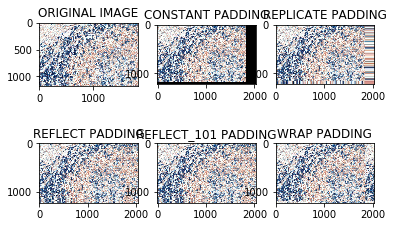

In [10]:
plt.subplot(231),plt.imshow(original_img,'gray'),plt.title('ORIGINAL IMAGE')
plt.subplot(232),plt.imshow(img_with_constant_padding,'gray'),plt.title('CONSTANT PADDING')
plt.subplot(233),plt.imshow(img_with_replicate_padding,'gray'),plt.title('REPLICATE PADDING')
plt.subplot(234),plt.imshow(img_with_reflect_padding,'gray'),plt.title('REFLECT PADDING')
plt.subplot(235),plt.imshow(img_with_reflect_101_padding,'gray'),plt.title('REFLECT_101 PADDING')
plt.subplot(236),plt.imshow(img_with_wrap_padding,'gray'),plt.title('WRAP PADDING')

plt.show()
plt.gcf().clear()

## Sanity Check - Create Patches

The following code iterates the generated patches along the x-axis.

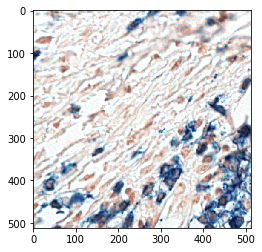

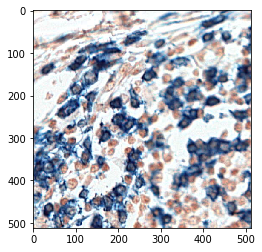

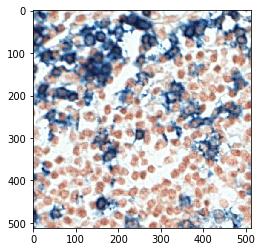

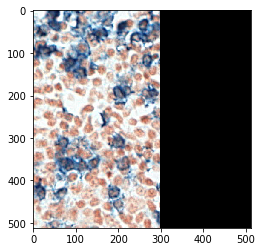

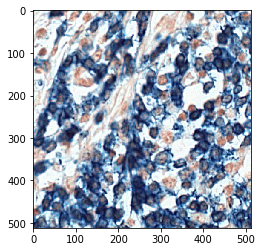

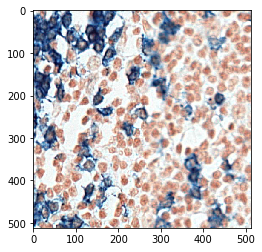

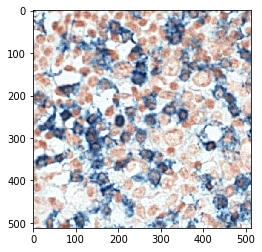

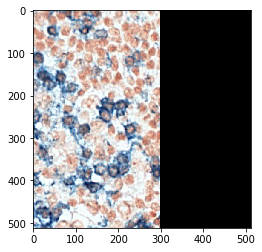

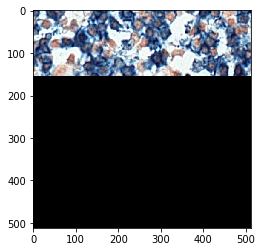

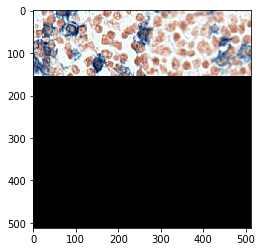

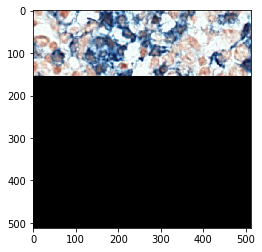

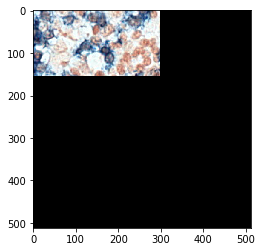

In [11]:
patches, original_height, original_width = create_patches_from_image(
    image_path=IMAGE_PATH, 
    patch_width=PATCH_WIDTH, 
    patch_height=PATCH_HEIGHT, 
    border_type=BORDER_TYPE)

row_count, column_count = (patches.shape[0:2])

# Show patches
for y in range(0,row_count):
    for x in range(0,column_count):
        plt.imshow(patches[y,x,:,:,:],'gray')
        plt.show()       
        
plt.gcf().clear()        

## Sanity Check - Image stitching

The *stitch_patches_to_image* function needs the numpy array of image patches and the width and height of the image it should produce at the end. You probably want to give the original width and height of the image so that the padding gets removed during the cropping process. It's your responsibility to save the original dimensions of the image somewhere in order to make this function work. If you specify a width and height then these arguments are used for cropping otherwise nothing gets cropped and you receive an image with padding.

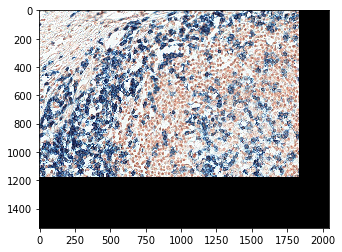

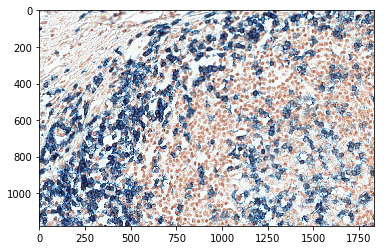

In [12]:
patches, original_height, original_width = create_patches_from_image(
    image_path=IMAGE_PATH, 
    patch_width=PATCH_WIDTH, 
    patch_height=PATCH_HEIGHT, 
    border_type=BORDER_TYPE)

output_with_padding = stitch_patches_to_image(patches)
output_without_padding = stitch_patches_to_image(patches, original_height, original_width)

plt.imshow(output_with_padding)
plt.show()

plt.imshow(output_without_padding)
plt.show()
        
plt.gcf().clear()        
    

### Loading the trained model
The U-net model from earlier training is loaded below.

In [13]:
## Load model, get predictions!
model = keras.models.load_model('weights.h5') #saved by our callback earlier

### Getting the images
Or their locations, rather.

In [14]:
image_paths = os.listdir(IMAGE_DIR)
print('Found {} validation images.'.format(len(image_paths))) # How many images do we actually have?

Found 78 validation images.


### Preparing a submission
The below code generates a dataframe in which to store the x,y - locations of the cells we find. It uses the skimage measure function, with credits to Francesco!

It includes some primitive filtering on cell size and region extent to reduce the amount of false positives that are submitted. 

In [15]:
def prepareSubmissionData(image_name, image):
    # define dataframe columns
    columns = ['image_id_roi_id', 'pixel_size','x', 'y', 'score']
   
    #create the dataframe used to store coordinates
    results = pd.DataFrame(columns=columns)
    #per image get the list of centroids
        
    labels = skimage.measure.label(image, background=0)
    regions = skimage.measure.regionprops(labels)
        
    #for each region found, add the data to the dataframe
    for region in regions:
        
        # only select blobs that have more than 250 pixels/voxels. Arbitrary number, needs to be optimal
        if region.area >= 250 and region.extent >= 0.6:
                
            temp = pd.DataFrame([[image_name, 0.24309392273426056, region.centroid[0].astype(int), region.centroid[1].astype(int), 1]], columns=columns)
            results = results.append(temp, ignore_index=True)
 
    return results

### Sanity checks
To have some human interpretable results the following two functions allow us to check the results. The first returns the number of clusters per image which was of course part of the original case for this project. 

The second stores the generated prediction map to file. 

In [16]:
# function to count the number of lymphocytes in a given image
def count_lymps(image):
    num = skimage.measure.label(image,  return_num=True)[1]
    return num

# function to store images in /results/
def store_image(result_dir, image_name, image):
    image = Image.fromarray(np.uint8(image*255), 'L')
    image.save(join(result_dir, image_name + '_predictions.png'))

# The good part - tying it all together
The next block ties all the functions defined above together. It generates a submission data frame and iterates through the images doing the following things.

* Loading the image from disk
* Splitting the image in patches
* Converting the images into a numpy array that can be shown to the network
* Making predictions per image
* Patching the image back together (literally)
* Calculating centroid coordinates (from the functiond defined above)
* Storing the results (the csv gets updated, and the images get stored to disk)

In [17]:
columns = ['image_id_roi_id', 'pixel_size','x', 'y', 'score']
submission = pd.DataFrame(columns=columns)
lymps = 0

# make dir for results if it does not already exist. 

if os.path.exists(result_dir):
    pass
else:
    os.system('mkdir -p ' + result_dir)


for idx, image_path in enumerate(image_paths):
    pre_patched_image = cv2.imread(IMAGE_DIR +'/'+ image_path)
    
    # print the step we're on because this may take a while.
    print("Processing image "+format(idx))
    
    # convert image to patches 
    patches, original_height, original_width = create_patches_from_image(
        image_path=IMAGE_DIR +'/'+ image_path, 
        patch_width=PATCH_WIDTH, 
        patch_height=PATCH_HEIGHT, 
        border_type=BORDER_TYPE)
    
    row_count, column_count = (patches.shape[0:2])

    # Array to store the images prior to prediction
    X_test = []
    
    # now create an array with num_samples, width, height, channels
    # instead of y, x, width, height, num_channels
    # as this is the input format of our networks
    for y in range(0,row_count):
        for x in range(0,column_count):
            X_test.append(np.asarray(patches[y,x,:, :, :])) 
    
    X_test = np.asarray(X_test)
    
    # Use the model to make a prediction
    preds = model.predict(X_test, verbose=1)
    
    # in order to put it back as one image, now we need to put it back into the y,x notation
    preds_patches = preds.reshape(row_count, column_count, PATCH_HEIGHT, PATCH_WIDTH, 1)  
    
    # get the stitched-back-together image
    output_without_padding = np.squeeze(stitch_patches_to_image(preds_patches, original_height, original_width))
    
    lymps_temp = count_lymps(output_without_padding)
    print('We found: '+format(lymps_temp)+' lymphocytes in this image!')
    lymps = lymps + lymps_temp
    
    # process image name
    image_name = image_path.split('.png')[0]
    
    # save the image before moving on
    store_image(result_dir, image_name, output_without_padding)
    
    # run annotation script on it and append submission with the new coordinates
    submission = submission.append(prepareSubmissionData(image_name, output_without_padding), ignore_index=True)   


Processing image 0
12/12 [==============================] - 4s 298ms/step
We found: 15 lymphocytes in this image!
Processing image 1
15/15 [==============================] - 3s 210ms/step
We found: 0 lymphocytes in this image!
Processing image 2
25/25 [==============================] - 5s 202ms/step
We found: 61 lymphocytes in this image!
Processing image 3
20/20 [==============================] - 4s 208ms/step
We found: 2 lymphocytes in this image!
Processing image 4
24/24 [==============================] - 5s 203ms/step
We found: 361 lymphocytes in this image!
Processing image 5
35/35 [==============================] - 7s 205ms/step
We found: 1072 lymphocytes in this image!
Processing image 6
20/20 [==============================] - 1s 57ms/step
We found: 37 lymphocytes in this image!
Processing image 7
30/30 [==============================] - 6s 194ms/step
We found: 515 lymphocytes in this image!
Processing image 8
12/12 [==============================] - 1s 54ms/step
We found: 259 

We found: 59 lymphocytes in this image!
Processing image 73
15/15 [==============================] - 1s 50ms/step
We found: 361 lymphocytes in this image!
Processing image 74
135/135 [==============================] - 9s 63ms/step
We found: 452 lymphocytes in this image!
Processing image 75
16/16 [==============================] - 1s 49ms/step
We found: 100 lymphocytes in this image!
Processing image 76
9/9 [==============================] - 1s 57ms/step
We found: 32 lymphocytes in this image!
Processing image 77
4/4 [==============================] - 0s 63ms/step
We found: 0 lymphocytes in this image!


Show some statistics on how many blobs we found (without paying attention to if the blob size corresponds to what we expect a lymphocyte to be, so the actual number is much lower)

In [18]:
print('We found '+format(lymps)+' blobs! That is a mean of '+format(lymps/len(image_paths))+' per image!')

We found 16666 blobs! That is a mean of 213.66666666666666 per image!


### Prepare the submission
In order to have the submission get processed on by Zanetta's evaluain script, here's another block to process the floating point score. As a sanity check it shows the first ten annotations.

In [21]:
submission[['score']] = submission[['score']].astype(int)
submission.head(10)

,image_id_roi_id,pixel_size,x,y,score
0,27_CD3_ROI_7,0.243094,242.0,1856.0,1
1,27_CD3_ROI_7,0.243094,919.0,370.0,1
2,27_CD3_ROI_7,0.243094,985.0,492.0,1
3,27_CD3_ROI_7,0.243094,1372.0,865.0,1
4,27_CD3_ROI_7,0.243094,1513.0,858.0,1
5,27_CD3_ROI_7,0.243094,1562.0,222.0,1
6,27_CD3_ROI_7,0.243094,1609.0,844.0,1
7,23-CD8_ROI_4,0.243094,10.0,10.0,1
8,23-CD8_ROI_4,0.243094,2.0,682.0,1
9,23-CD8_ROI_4,0.243094,5.0,764.0,1


Finally, generate the csv file:

In [20]:
submission.to_csv("submission.csv", encoding="utf-8", index=False)

Click the following link to download it (save-as)

[Click me](submission.csv)